In [1]:
%autoreload 2

In [2]:
from collections import defaultdict
import os
import sys

import matplotlib.pyplot as plt
import numpy as np

sys.path.append(os.path.abspath('..'))

import llm_feedback.pilot.tasks as tasks
from llm_feedback.utils.io import read_json


In [3]:
MBPP_OUTPUT_PATH = '../outputs/gpt-3.5-turbo-0301__gpt-3.5-turbo-0301__gpt-3.5-turbo-0301__mbpp__train__metrics.json'

mbpp_outputs = read_json(MBPP_OUTPUT_PATH)

In [9]:
TEST_ID_KEYS = ['0', '1', '2']
INITIAL_SOLUTION = 'initial_solution'
REFINEMENT = 'refinement'
COMPLETION_ID_KEY = 'completion_id'
RESULT_FIELD = 'result'
PASSED_FIELD = 'passed'

accuracy_by_problem = {INITIAL_SOLUTION: [], REFINEMENT: []}
all_problem_result_summaries = []

missing_names = defaultdict(set)
exception_types = defaultdict(set)

for problem_id, problem_results in enumerate(mbpp_outputs):
    problem_results_summary = {INITIAL_SOLUTION: [], REFINEMENT: []}
    for test_id in TEST_ID_KEYS:
        test_results = problem_results[test_id]
        for _, code_test_results in test_results:
            code_type = INITIAL_SOLUTION if code_test_results[COMPLETION_ID_KEY] == 0 else REFINEMENT
            code_test_result = code_test_results[RESULT_FIELD]
            if code_test_result is None:
                print(f'Problem {problem_id}, test {test_id} has result None')
            if 'is not defined' in code_test_result.lower():
                # print(f'Problem {problem_id}, test {test_id} has defintion issues: {code_test_result}')
                name_index = code_test_result.find('name')
                if name_index != -1:
                    space_index = code_test_result.find(' ', name_index)
                    next_space_index = code_test_result.find(' ', space_index + 1)
                    missing_name = code_test_result[space_index + 1:next_space_index]
                    missing_names[missing_name.replace("'", '')].add(problem_id)
            if '<class' in code_test_result:
                exception_class_index = code_test_result.find('<class')
                exception_start = code_test_result.find("'", exception_class_index)
                exception_end = code_test_result.find("'", exception_start + 1)
                exception_type = code_test_result[exception_start + 1:exception_end]
                exception_types[exception_type].add(problem_id)
            code_test_passed = code_test_results[PASSED_FIELD]
            if code_test_passed is None:
                print(f'Problem {problem_id}, test {test_id} has passed None')
                code_test_passed = False
            problem_results_summary[code_type].append(code_test_passed)

    all_problem_result_summaries.append(problem_results_summary)
    accuracy_by_problem[INITIAL_SOLUTION].append(np.mean(problem_results_summary[INITIAL_SOLUTION]))
    accuracy_by_problem[REFINEMENT].append(np.mean(problem_results_summary[REFINEMENT]))
            


In [10]:
missing_names

defaultdict(set,
            {'Pair': {0},
             'radian_degree': {5},
             'bell_Number': {7},
             'cummulative_sum': {13},
             'Split': {28},
             'pair_OR_Sum': {32},
             'sample_nam': {38},
             're': {39},
             'is_nonagonal': {40},
             'grouping_dictionary': {52},
             'sum_Of_Primes': {84}})

In [55]:
exception_types

defaultdict(set,
            {'NameError': {0, 5, 7, 13, 28, 32, 38, 39, 40, 52, 84},
             'AssertionError': {1,
              2,
              8,
              11,
              16,
              18,
              19,
              25,
              29,
              30,
              31,
              35,
              37,
              39,
              41,
              51,
              62,
              63,
              67,
              68,
              69,
              73,
              76,
              83,
              89,
              98},
             'SyntaxError': {3, 57, 58, 85},
             'ZeroDivisionError': {16},
             'TypeError': {34, 52},
             'NotImplementedError': {70}})

In [21]:
accuracy_by_solution_type = {k: np.mean(v) for k, v in accuracy_by_problem.items()}
accuracy_by_solution_type

{'initial_solution': 0.7466666666666667, 'refinement': 0.6833333333333332}

In [22]:
full_accuracy_rate_by_solution_type = {k: np.mean(np.array(v) == 1.0) for k, v in accuracy_by_problem.items()}
full_accuracy_rate_by_solution_type

{'initial_solution': 0.7, 'refinement': 0.64}

In [23]:
feedback_acuracy_change_by_problem = np.array([accuracy_by_problem[REFINEMENT][i] - accuracy_by_problem[INITIAL_SOLUTION][i] for i in range(len(accuracy_by_problem[REFINEMENT]))])
feedback_change_indices = np.where(feedback_acuracy_change_by_problem != 0)[0]
feedback_acuracy_change_by_problem[feedback_change_indices], feedback_change_indices, len(feedback_change_indices)

(array([ 1.        , -1.        , -1.        , -1.        ,  0.66666667,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
         1.        , -1.        ,  1.        , -1.        , -0.33333333,
        -1.        ,  1.        ,  0.33333333]),
 array([ 3,  5,  7, 13, 18, 28, 30, 31, 32, 40, 57, 63, 67, 73, 76, 84, 85,
        89]),
 18)

In [36]:
for i, delta in enumerate(feedback_acuracy_change_by_problem):
    if delta < 0:
        print(i, mbpp_outputs[i]['feedback'])

5 OK. The solution is correct and passes the unit tests.
7 OK.
13 OK.
28 OK.
30 The given solution replaces whitespaces with an underscore. However, the task description asks to replace both whitespaces and underscores with each other. You need to add an additional regex to replace underscores with whitespaces.
31 OK.
32 OK
40 OK
63 The solution is almost correct, but it fails to calculate the correct average for input 4. Instead of dividing the sum by n/2, it should divide it by (n/2)+1.
73 OK.
76 The function correctly checks if the sum of angles is 180 and if all angles are positive, but it doesn't check if the sum of any two angles is greater than the third angle, which is the condition for a valid triangle. Add this check to the function.
84 OK.


In [110]:
# SyntaxError, ZeroDivisionError, TypeError, NotImplementedError
# Indices to re-check: 34, 52, 57, 85
exception_types['SyntaxError']

{3, 57, 58, 85}

In [112]:
i =57
print(mbpp_outputs[i]['text'])
print(mbpp_outputs[i]['initial_solution'])
print(mbpp_outputs[i]['feedback'])
print(mbpp_outputs[i]['refinement'])

for test_id in TEST_ID_KEYS:
    print(mbpp_outputs[i][f'test_list_{test_id}'])
    results = [test_results[1]['result'] for test_results in mbpp_outputs[i][test_id]]
    print(results)


Write a function to find the item with maximum occurrences in a given list.
def max_occurrences(lst):
    counts = {}
    for item in lst:
        if item in counts:
            counts[item] += 1
        else:
            counts[item] = 1
    max_count = max(counts.values())
    for key, value in counts.items():
        if value == max_count:
            return key
OK.
def max_occurrences(lst):
    counts = {}
    for item in lst:
        counts[item] = counts.get(item, 0) + 1
    max_count = max(counts.values())
    for key, value in counts.items():
        if value == max_count:
            return key
assert max_occurrences([2,3,8,4,7,9,8,2,6,5,1,6,1,2,3,4,6,9,1,2])==2
["failed (<class 'SyntaxError'>): ('Line 5: Augmented assignment of object items and slices is not allowed.',)", 'passed']
assert max_occurrences([1, 3,5, 7,1, 3,13, 15, 17,5, 7,9,1, 11])==1
["failed (<class 'SyntaxError'>): ('Line 5: Augmented assignment of object items and slices is not allowed.',)", 'passed']
assert

In [92]:
import heapq

def heap_sort(lst):
    heap = []
    for value in lst:
        heapq.heappush(heap, value)
    
    ordered = []
    while heap:
        ordered.append(heapq.heappop(heap))
    
    return ordered

assert heap_sort([1, 3, 5, 7, 9, 2, 4, 6, 8, 0])==[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
assert heap_sort([25, 35, 22, 85, 14, 65, 75, 25, 58])==[14, 22, 25, 25, 35, 58, 65, 75, 85]
assert heap_sort( [7, 1, 9, 5])==[1,5,7,9]


In [ ]:
mbpp_outputs[i]['0']

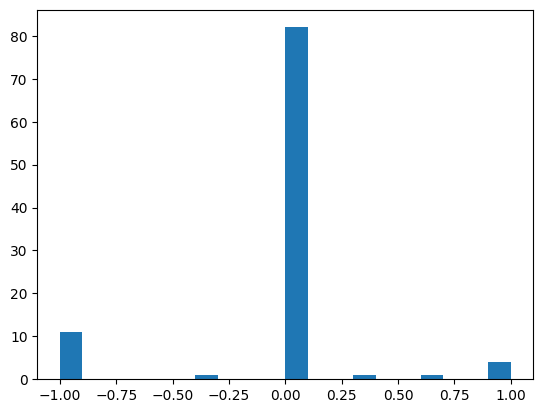

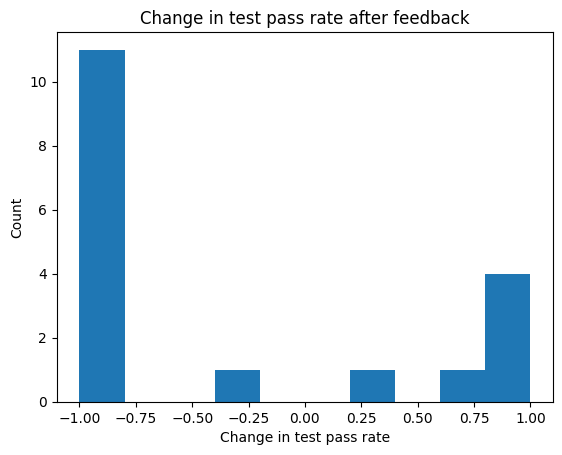

In [35]:
plt.hist(feedback_acuracy_change_by_problem, bins=20)
plt.show()
plt.hist(feedback_acuracy_change_by_problem[feedback_change_indices])
plt.title('Change in test pass rate after feedback')
plt.ylabel('Count')
plt.xlabel('Change in test pass rate')
plt.show()

In [116]:
from evaluate import load
import re
code_eval = load("guydav/restrictedpython_code_eval")
markdown_pattern = re.compile(r"```\w*")

import os
os.environ["HF_ALLOW_CODE_EVAL"] = '1'

DEFAULT_ADDITIONAL_GLOBALS = {
    'all': all,
    'dict': dict,
    'filter': filter,
    'map': map,
    'max': max,
    'sum': sum,
}

In [117]:
# Indices to re-check: 57, 85


output = mbpp_outputs[58]

test_cases = [output[key] for key in ('test_list_0', 'test_list_1', 'test_list_2')]
solutions = [output['initial_solution'], output['refinement']]
for solution in solutions:
    print(solution)
solutions = [markdown_pattern.sub('', solution).strip() for solution in solutions]
r = code_eval.compute(
    references=test_cases, 
    predictions=[solutions] * len(test_cases), 
    k=[len(solutions)],
    allowed_imports=['typing', 'collections', 'math', 're', 'heapq'],
    additional_globals=DEFAULT_ADDITIONAL_GLOBALS,
    allow_str_format=True,
    allow_underscore_variable_names=True,
    )[1]  # type: ignore

r

def Repeat(x):
    _size = len(x)
    repeated = []
    for i in range(_size):
        k = i + 1
        for j in range(k, _size):
            if x[i] == x[j] and x[i] not in repeated:
                repeated.append(x[i])
    return repeated

print(Repeat([10, 20, 30, 20, 20, 30, 40, 50, -20, 60, 60, -20, -20]))
def find_duplicates(x):
    _size = len(x)
    repeated = []
    for i in range(_size):
        if x[i] in x[i+1:] and x[i] not in repeated:
            repeated.append(x[i])
    return repeated

print(find_duplicates([10, 20, 30, 20, 20, 30, 40, 50, -20, 60, 60, -20, -20]))


defaultdict(list,
            {0: [(0,
               {'task_id': 0,
                'passed': True,
                'result': 'passed',
                'completion_id': 0}),
              (1,
               {'task_id': 0,
                'passed': False,
                'result': "failed (<class 'NameError'>): name 'Repeat' is not defined",
                'completion_id': 1})],
             1: [(0,
               {'task_id': 1,
                'passed': True,
                'result': 'passed',
                'completion_id': 0}),
              (1,
               {'task_id': 1,
                'passed': False,
                'result': "failed (<class 'NameError'>): name 'Repeat' is not defined",
                'completion_id': 1})],
             2: [(0,
               {'task_id': 2,
                'passed': True,
                'result': 'passed',
                'completion_id': 0}),
              (1,
               {'task_id': 2,
                'passed': False,
              

In [ ]:
solutions